# Projekt

### Konfiguracja

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from copy import deepcopy

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [16]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


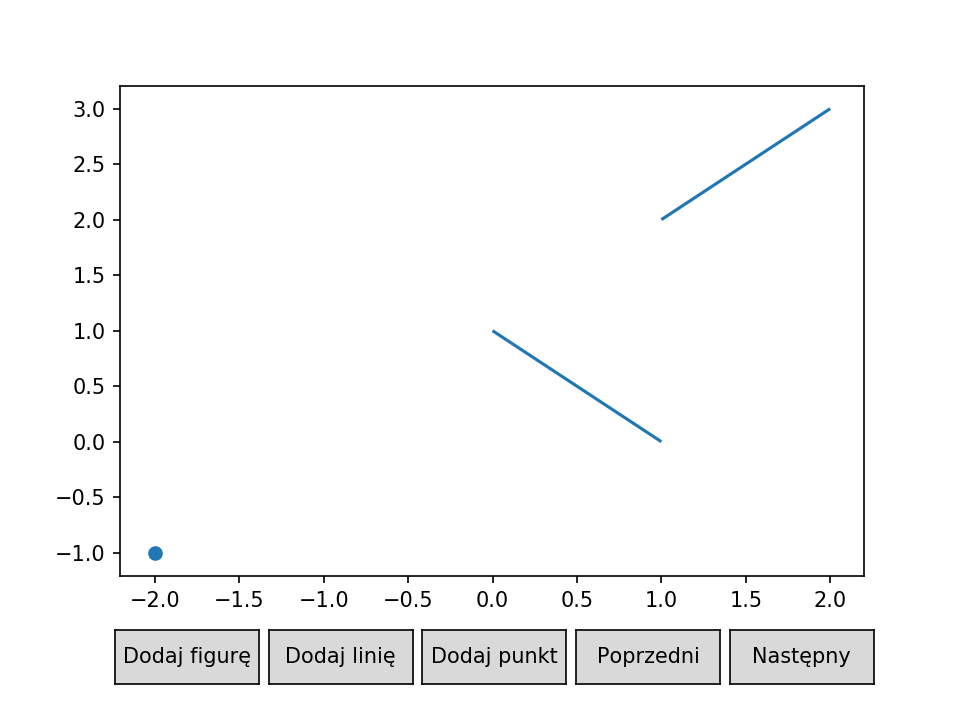

In [17]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Algorytm Sutherlanda-Hodgmana

In [68]:
# algorytm Sutherlanda-hodgmana -> konieczne, aby punkty jako wejście były zgodnie ze wskazówkami zegara

def SutherlandHodgman(pointsOfSubjectPolygon, linesOfClippingPolygon):
    visualizer_args = []
    outputList = deepcopy(pointsOfSubjectPolygon)
    
    for clipEdge in linesOfClippingPolygon:
        inputList = deepcopy(outputList)
        outputList.clear()
        
        for index in range(len(inputList)):
            current_point = inputList[index]
            prev_point = inputList[(index + len(inputList) - 1) % len(inputList)]
            visualizer_args.append([inputList, clipEdge, current_point, prev_point])
            
            subjectEdge = [prev_point, current_point]
            if doLinesIntersect(subjectEdge, clipEdge):
                intersecting_point = findIntersection(clipEdge, subjectEdge)
              
            if isPointInClipEdge(current_point, clipEdge):
                if not isPointInClipEdge(prev_point, clipEdge):
                    outputList.append(intersecting_point)
                    visualizer_args.append([inputList, clipEdge, current_point, prev_point, intersecting_point])
                outputList.append(current_point)
            elif isPointInClipEdge(prev_point, clipEdge):
                outputList.append(intersecting_point)
                visualizer_args.append([inputList, clipEdge, current_point, prev_point, intersecting_point])
    
    return (outputList, visualizer_args)


def doLinesIntersect(section1, section2):
    vector1 = (section1[1][0]-section1[0][0],section1[1][1]-section1[0][1])
    vector2 = (section2[1][0]-section2[0][0],section2[1][1]-section2[0][1])
    
    matrix = [[vector1[0], vector1[1]],[vector2[0], vector2[1]]]
    det = np.linalg.det(matrix)
    
    return not (det==0)


def pointPosTowardsLine(point, line_points):
    epsilon = 10**(-6)
    base_matrix = [[line_points[0][0], line_points[0][1], 1.0],[line_points[1][0], line_points[1][1], 1.0],[point[0], point[1], 1.0]]
    determinant = np.linalg.det(base_matrix)
    
    if determinant > epsilon:
        return 1
    elif determinant < (-1)*epsilon:
        return -1
    else:
        return 0


def isPointInClipEdge(point, clipEdge):
    return pointPosTowardsLine(point, clipEdge) == -1


def findIntersection(section1, section2):
    (x1, y1) = section1[0]
    (x2, y2) = section1[1]
    (x3, y3) = section2[0]
    (x4, y4) = section2[1]
    x = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/((x1-x2) * (y3-y4) - (y1-y2) * (x3-x4))
    y = ((x1*y2 - y1*x2) * (y3-y4)-(y1-y2) * (x3*y4 - y3*x4))/((x1-x2) * (y3-y4) - (y1-y2) * (x3-x4))
    
    return (x, y)

### Znajdowanie iloczynu i sumy wielokątów

In [69]:
%matplotlib notebook


def findPolygonsIntersection(figure1, figure2): 
    pointsOfFigure1 = getPointOutOfLines(figure1)
    
    (intersections, visualizer) = SutherlandHodgman(pointsOfFigure1, figure2)
    
    figure = []
    for index in range(len(intersections)):
        figure.append([intersections[index], intersections[(index+1)%len(intersections)]])
    
    return (figure, visualizer)


def findPolygonsSum(figure1, figure2):
    pointsOfFigure1 = getPointOutOfLines(figure1)
    pointsOfFigure2 = getPointOutOfLines(figure2)
    
    (intersections, visualizer) = SutherlandHodgman(pointsOfFigure1, figure2)
    
    figure=[]
    figure.extend(pointsOfFigure1)
    figure.extend(pointsOfFigure2)
    
    for inter in intersections:
        if inter in figure:
            figure.remove(inter)
        else:
            figure.append(inter)
    
    centre_point = (np.mean(figure,axis=0)[0], np.mean(figure,axis=0)[1])
    figure_in_polar = []
    for index in range(len(figure)):
        (x, y) = figure[index]
        x -= centre_point[0]
        y -= centre_point[1]
        figure_in_polar.append((np.sqrt(x**2+y**2), np.arctan2(y, x)))
        
    figure_in_polar.sort(key = lambda x: x[1], reverse = True)
    
    figure_as_lines = []
    for index in range(len(figure_in_polar)):
        (r1,fi1) = figure_in_polar[index]
        (r2,fi2) = figure_in_polar[(index+1)%len(figure_in_polar)]
        point1 = (r1*np.cos(fi1)+centre_point[0], r1*np.sin(fi1)+centre_point[1])
        point2 = (r2*np.cos(fi2)+centre_point[0], r2*np.sin(fi2)+centre_point[1])
        
        figure_as_lines.append([point1, point2])
    
    return (figure_as_lines, visualizer)


def getPointOutOfLines(list_of_lines):
    points = []
    
    for line in list_of_lines:
        if line[0] not in points:
            points.append(line[0])
            
        if line[1] not in points:
            points.append(line[1])
    
    return points


### Interaktywny przykład

<IPython.core.display.Javascript object>


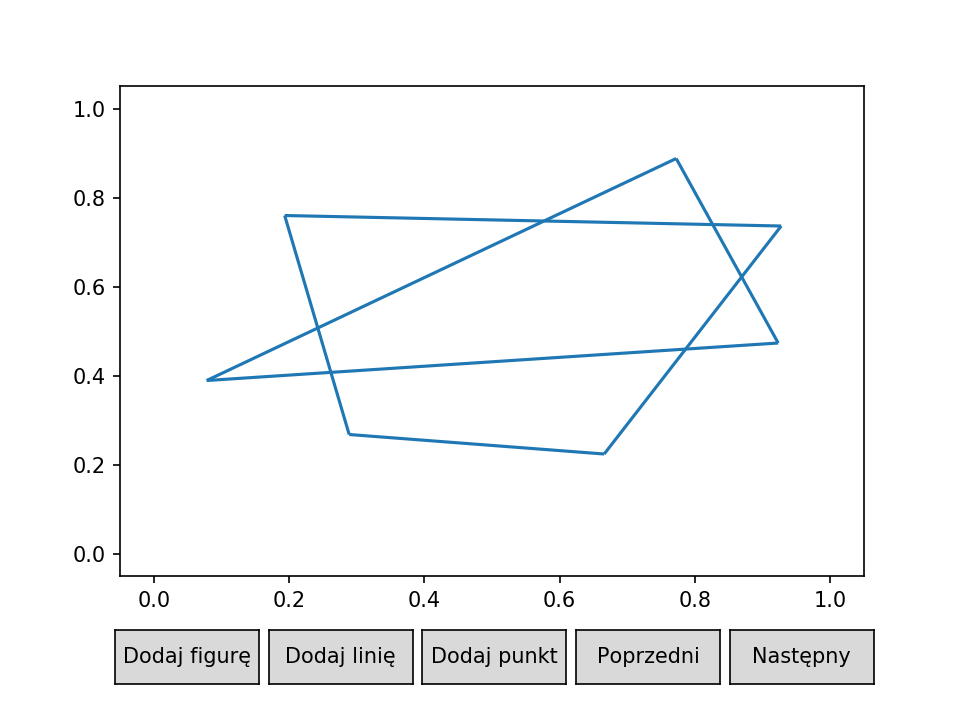

In [70]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


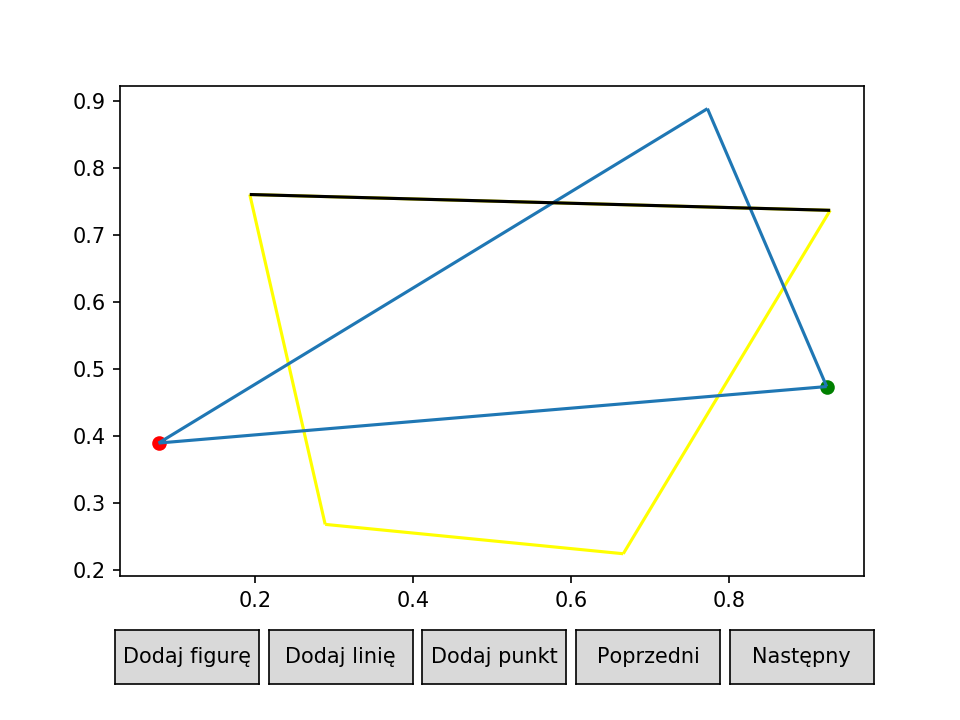

In [78]:
# plot2 = Plot([plot1.get_added_figure()])
# added_lines = plot1.get_added_elements().lines

def convertVisualizer(visualizer_args, figure2):
    scenes = []
    
    for index in range(len(visualizer_args)):
        args = visualizer_args[index]
        args_no = len(args)
        lines_to_draw = [LinesCollection(figure2, color='yellow')]
        points_of_figure = args[0]
        lines_of_figure = []
        for index in range(len(points_of_figure)):
            lines_of_figure.append([points_of_figure[index], points_of_figure[(index+1)%len(points_of_figure)]])
        
        lines_to_draw.append(LinesCollection(lines_of_figure))
        clipEdge = args[1]
        lines_to_draw.append(LinesCollection([clipEdge], color='black'))
        curr_point = args[2]
        prev_point = args[3]
        points_to_draw = [PointsCollection([curr_point], color='red'), PointsCollection([prev_point], color='green')]
        if args_no > 4:
            points_to_draw.append(PointsCollection([args[4]], color='orange'))
        
        scenes.append(Scene(points_to_draw,lines=lines_to_draw))
        
    return scenes
        
added_figs = plot1.get_added_figure()

figures = []

for line_collection in added_figs:
    if len(line_collection.lines) != 0:
        figures.append(line_collection.lines)

(intersection, visualizer_args) = findPolygonsIntersection(figures[0], figures[1])

scenes = convertVisualizer(visualizer_args, figures[1])
scenes.append(Scene(lines=[LinesCollection(figures[1], color='yellow'), LinesCollection(intersection)]))
scenes.append(Scene(lines=[LinesCollection(figures[0]), LinesCollection(figures[1], color='yellow'),
                      LinesCollection(intersection, color='red')]))

#scene1 = Scene(lines=[LinesCollection(figures[0], color='blue'), LinesCollection(figures[1], color='green')])
#scene2 = Scene(lines=[LinesCollection(figures[0], color='blue'), LinesCollection(figures[1], color='green'),
#                      LinesCollection(intersection, color='red')])

plot = Plot(scenes)

plot.draw()

### Testy

Points of intersection:  [[(200.0, 200.0), (200.0, 175.0)], [(200.0, 175.0), (150.0, 162.5)], [(150.0, 162.5), (150.0, 200.0)], [(150.0, 200.0), (200.0, 200.0)]]
Expected: (150, 162) (150, 200) (200, 200) (200, 174)
Points of sum: [[(200.0, 250.0), (300.0, 200.0)], [(300.0, 200.0), (200.0, 175.0)], [(200.0, 175.0), (200.0, 150.0)], [(200.0, 150.0), (150.0, 150.0)], [(150.0, 150.0), (150.0, 162.5)], [(150.0, 162.5), (100.0, 150.0)], [(100.0, 150.0), (200.0, 250.0)]]
expected: (100, 150) (200, 250) (300, 200) (200, 174) (200, 150) (150, 150) (150, 162)


<IPython.core.display.Javascript object>


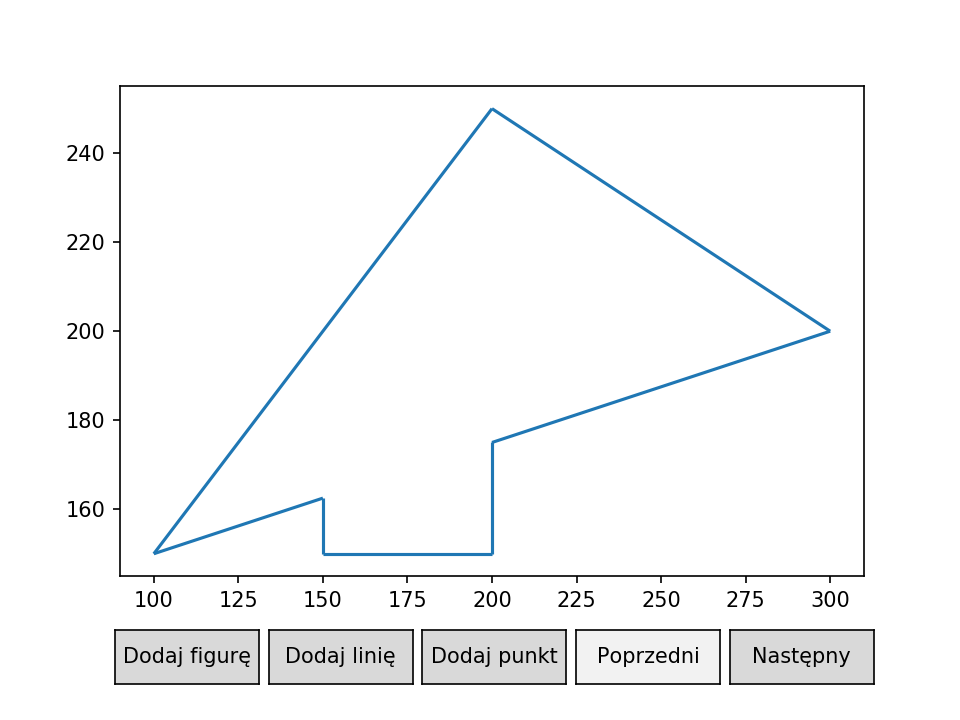

In [14]:
# ----------------
figure1 = [[(100,150),(200,250)], [(200,250),(300,200)], [(300,200),(100,150)]]
#figure1 = [(100,150), (200,250), (300,200)]
figure2 = [[(150,150), (150,200)], [(150,200), (200,200)], [(200,200),(200,150)],[(200,150),(150,150)]]
intersection = findPolygonsIntersection(figure1, figure2)
print("Points of intersection: ", intersection)
print("Expected:", (150, 162), (150, 200), (200, 200), (200, 174))
scene3 = Scene(lines=[LinesCollection(intersection, color='blue')])
# --------------
# -------------
pol_sum = findPolygonsSum(figure1, figure2)
inters = []
for 
print("Points of sum:", pol_sum)
print("expected:", (100,150), (200,250), (300,200), (200, 174), (200, 150), (150, 150), (150, 162))
scene1 = Scene(lines=[LinesCollection(pol_sum)])
scene2 = Scene(lines=[LinesCollection(figure1, color='red'), LinesCollection(figure2, color='green')])
plot = Plot([scene1, scene2, scene3])
plot.draw()

### Przykłady z plików

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


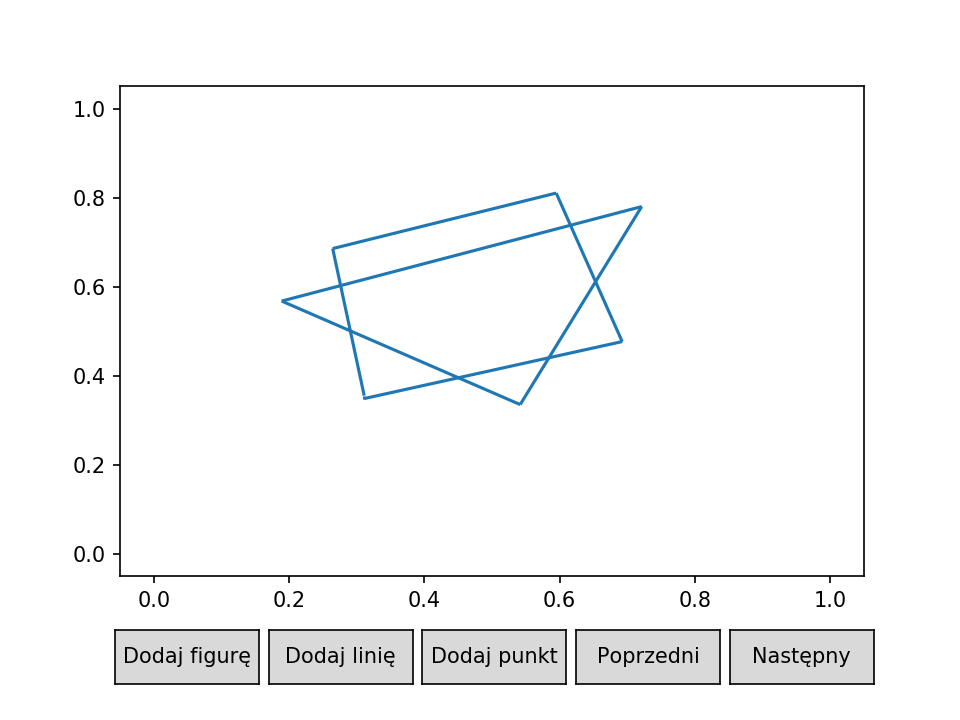

In [100]:
#Dodaj tu punkty, figury i/lub odcinki!
# zrobić zapis przykładów do plików
plot1 = Plot()
plot1.draw()

In [9]:
plot2 = Plot([plot1.get_added_elements()])

with open('example1.json', 'w') as file:
    file.write(plot2.toJson())

plot2.draw()

NameError: name 'plot1' is not defined

### Testy - zrobić wizualizację na przykładach z pliku

In [105]:
# działa wyciąganie linii dodanych, nie działa znajdowanie przecięć
added_lines = plot1.get_added_elements().lines

lines = []

for line in added_lines:
    if len(line.lines) != 0:
        lines.append(line.lines)

print(lines[0])
print(lines[1])
print("-----")

intersections = findPolygonsIntersection(lines[0], lines[1])
print("Found points: ", intersections)



[[(0.5416750446442635, 0.33513901654411754), (0.18905407690232806, 0.56767578125)], [(0.18905407690232806, 0.56767578125), (0.7213121414184571, 0.779991957720588)], [(0.7213121414184571, 0.779991957720588), (0.5416750446442635, 0.33513901654411754)]]
[[(0.311029883353941, 0.34861940870098035), (0.311029883353941, 0.3553596047794117)], [(0.311029883353941, 0.3553596047794117), (0.26445730270877965, 0.685629212622549)], [(0.26445730270877965, 0.685629212622549), (0.5949008510958764, 0.8103228400735294)], [(0.5949008510958764, 0.8103228400735294), (0.6924814962571668, 0.4766831341911764)], [(0.6924814962571668, 0.4766831341911764), (0.311029883353941, 0.34861940870098035)]]
-----
Found points:  [[(0.6531443648382739, 0.6111814144101848), (0.5841450400092011, 0.4403116267071067)], [(0.5841450400092011, 0.4403116267071067), (0.45032042206902173, 0.39538304715468686)], [(0.45032042206902173, 0.39538304715468686), (0.311029883353941, 0.4872385355970216)], [(0.311029883353941, 0.48723853559702